## 3) Run optimization 

In this notebook we use the previously computed features to fit the cell model parameters and save the results.

We can run optimization on a subset of samples/feature sets.

In [34]:
%load_ext autoreload
%autoreload

#!nrnivmodl mechanisms
import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import matplotlib.pyplot as plt
import MEAutility as mu
import json
import numpy
import time
import numpy as np
import LFPy
from pathlib import Path
import pandas as pd
import os
from ipyparallel import Client

%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import l5pc_model
import l5pc_evaluator

### Set up ipyparallel processing

In [150]:
try:
    rc = Client() # profile=os.getenv('IPYTHON_PROFILE')
    lview = rc.load_balanced_view()
    
    def mapper(func, it):
        start_time = time.time()
        ret = lview.map_sync(func, it)
        print(f'Generation {it} took {time.time() - start_time} s')
        return ret
except:
    mapper = None

if mapper is not None:
    print(f'IPyparallel started successfully with {len(rc)} parallel processes')

IPyparallel started successfully with 25 parallel processes


In [87]:
feature_sets = ['soma']  # ['soma', 'bap', 'extra']
sample_ids = [0] # [0, ..., n_samples]

offspring_size = 250
max_ngen = 50
channels = None

# define map_function
map_function=mapper

In [88]:
random_params_file = 'config/params/random.csv'
random_params = pd.read_csv(random_params_file, index_col='index')
params = random_params.iloc[0].to_dict()

In [137]:
def prepare_optimization(feature_set, sample_id, offspring_size=10, config_path='config',
                         channels=None, map_function=None):
    config_path = Path(config_path)
    morphology = ephys.morphologies.NrnFileMorphology('morphology/C060114A7.asc', do_replace_axon=True)
    param_configs = json.load(open('config/parameters.json'))
    parameters = l5pc_model.define_parameters()
    mechanisms = l5pc_model.define_mechanisms()

    cell = ephys.models.LFPyCellModel('l5pc', v_init=-65., morph=morphology, mechs=mechanisms, params=parameters)

    param_names = [param.name for param in cell.params.values() if not param.frozen]      

    if feature_set == "extra":
        probe_file = config_path / 'features' / f'random_{sample_id}' / 'probe.json'
        with probe_file.open('r') as f:
            info = json.load(f)
        probe = mu.return_mea(info=info)
        electrode = LFPy.RecExtElectrode(probe=probe)
    else:
        probe = None
        electrode = None 

    fitness_protocols = l5pc_evaluator.define_protocols(electrode=electrode) 
    sim = ephys.simulators.LFPySimulator(LFPyCellModel=cell, cvode_active=True, electrode=electrode)

    feature_file = config_path / 'features' / f'random_{sample_id}' / f'{feature_set}.json'
    fitness_calculator = l5pc_evaluator.define_fitness_calculator(protocols=fitness_protocols, 
                                                                  feature_file=feature_file, 
                                                                  probe=probe, channels=channels)
    evaluator = ephys.evaluators.CellEvaluator(cell_model=cell, 
                                               param_names=param_names,     
                                               fitness_protocols=fitness_protocols, 
                                               fitness_calculator=fitness_calculator,     
                                               sim=sim) 
    
    opt = bpopt.optimisations.DEAPOptimisation(evaluator=evaluator,  
                                               offspring_size=offspring_size,
                                               map_function=map_function) 
    
    output = {'optimisation': opt, 'evaluator': evaluator, 'objectives_calculator': fitness_calculator,
              'protocols': fitness_protocols}
    
    return output

In [138]:
def run_optimization(feature_set, sample_id, opt, max_ngen):
    cp_filename = Path('checkpoints') /  f'random_{sample_id}' /  f'{feature_set}_off{opt.offspring_size}_ngen{max_ngen}.pkl'
    if not cp_filename.parent.is_dir():
        os.makedirs(cp_filename.parent)
    t_start = time.time()
    final_pop, halloffame, log, hist = opt.run(max_ngen=max_ngen, cp_filename=cp_filename)
    t_stop = time.time()
    print('Optimization time', t_stop - t_start)
    
    output = {'final_pop': final_pop, 'halloffame': halloffame, 'log': log, 'hist': hist}
    return output

In [151]:
prep = prepare_optimization('extra', 0, offspring_size=offspring_size, channels=channels,
                             map_function = map_function)
opt = prep['optimisation']
evaluator = prep['evaluator']
fitness_calculator = prep['objectives_calculator']
fitness_protocols = prep['protocols']

In [ ]:
out = run_optimization('extra', 0, opt, max_ngen=max_ngen)

In [ ]:
final_pop = out['final_pop']
halloffame = out['halloffame']
log = out['log']
hist = out['hist']

In [ ]:
best_params = evaluator.param_dict(halloffame[0])
t_start = time.time()
best_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=best_params)
t_stop = time.time()
print(f'Time one protocol: {t_stop - t_start} s')

In [148]:
original_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=params)

In [144]:
def plot_responses(responses):
    resp_no_mea = {}
    for (resp_name, response) in sorted(responses.items()):
        if 'MEA' not in resp_name:
            resp_no_mea[resp_name] = response
    fig, axes = plt.subplots(len(resp_no_mea), figsize=(10,10))
    for index, (resp_name, response) in enumerate(sorted(resp_no_mea.items())):
        axes[index].plot(response['time'], response['voltage'], label=resp_name)
        axes[index].set_title(resp_name)
    fig.tight_layout()
    fig.show()

<IPython.core.display.Javascript object>


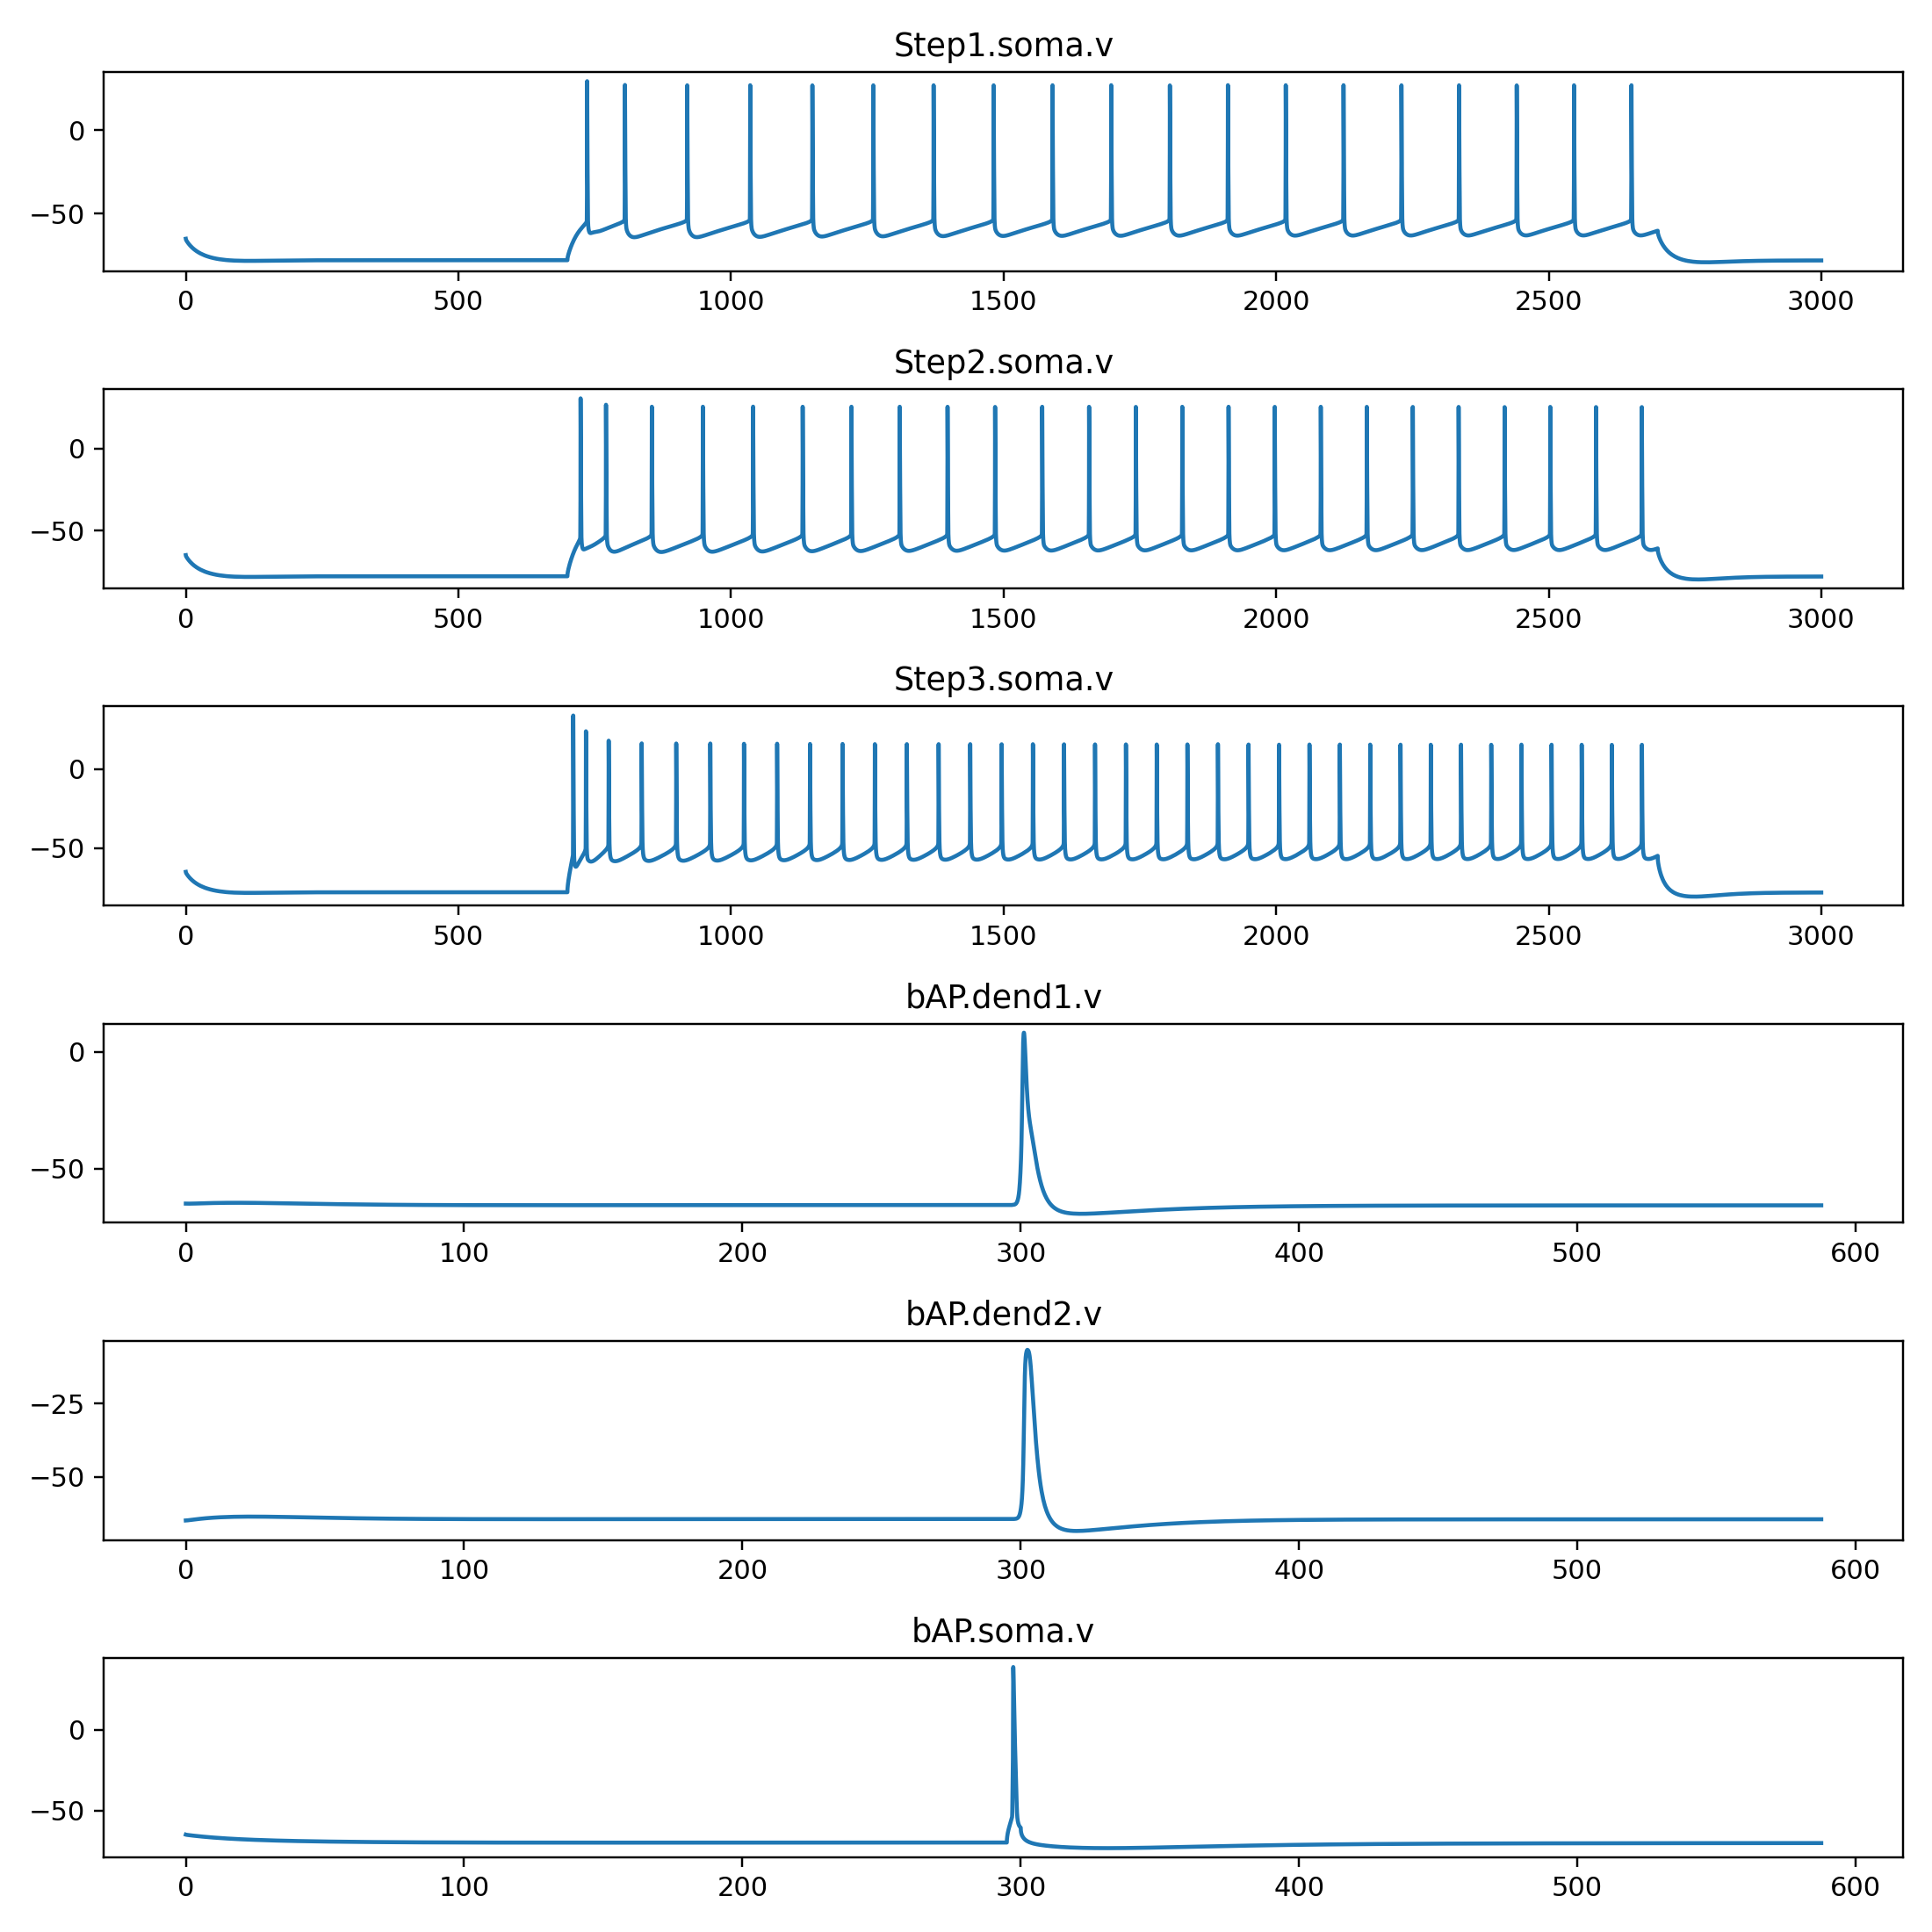

In [145]:
plot_responses(best_responses)

<IPython.core.display.Javascript object>


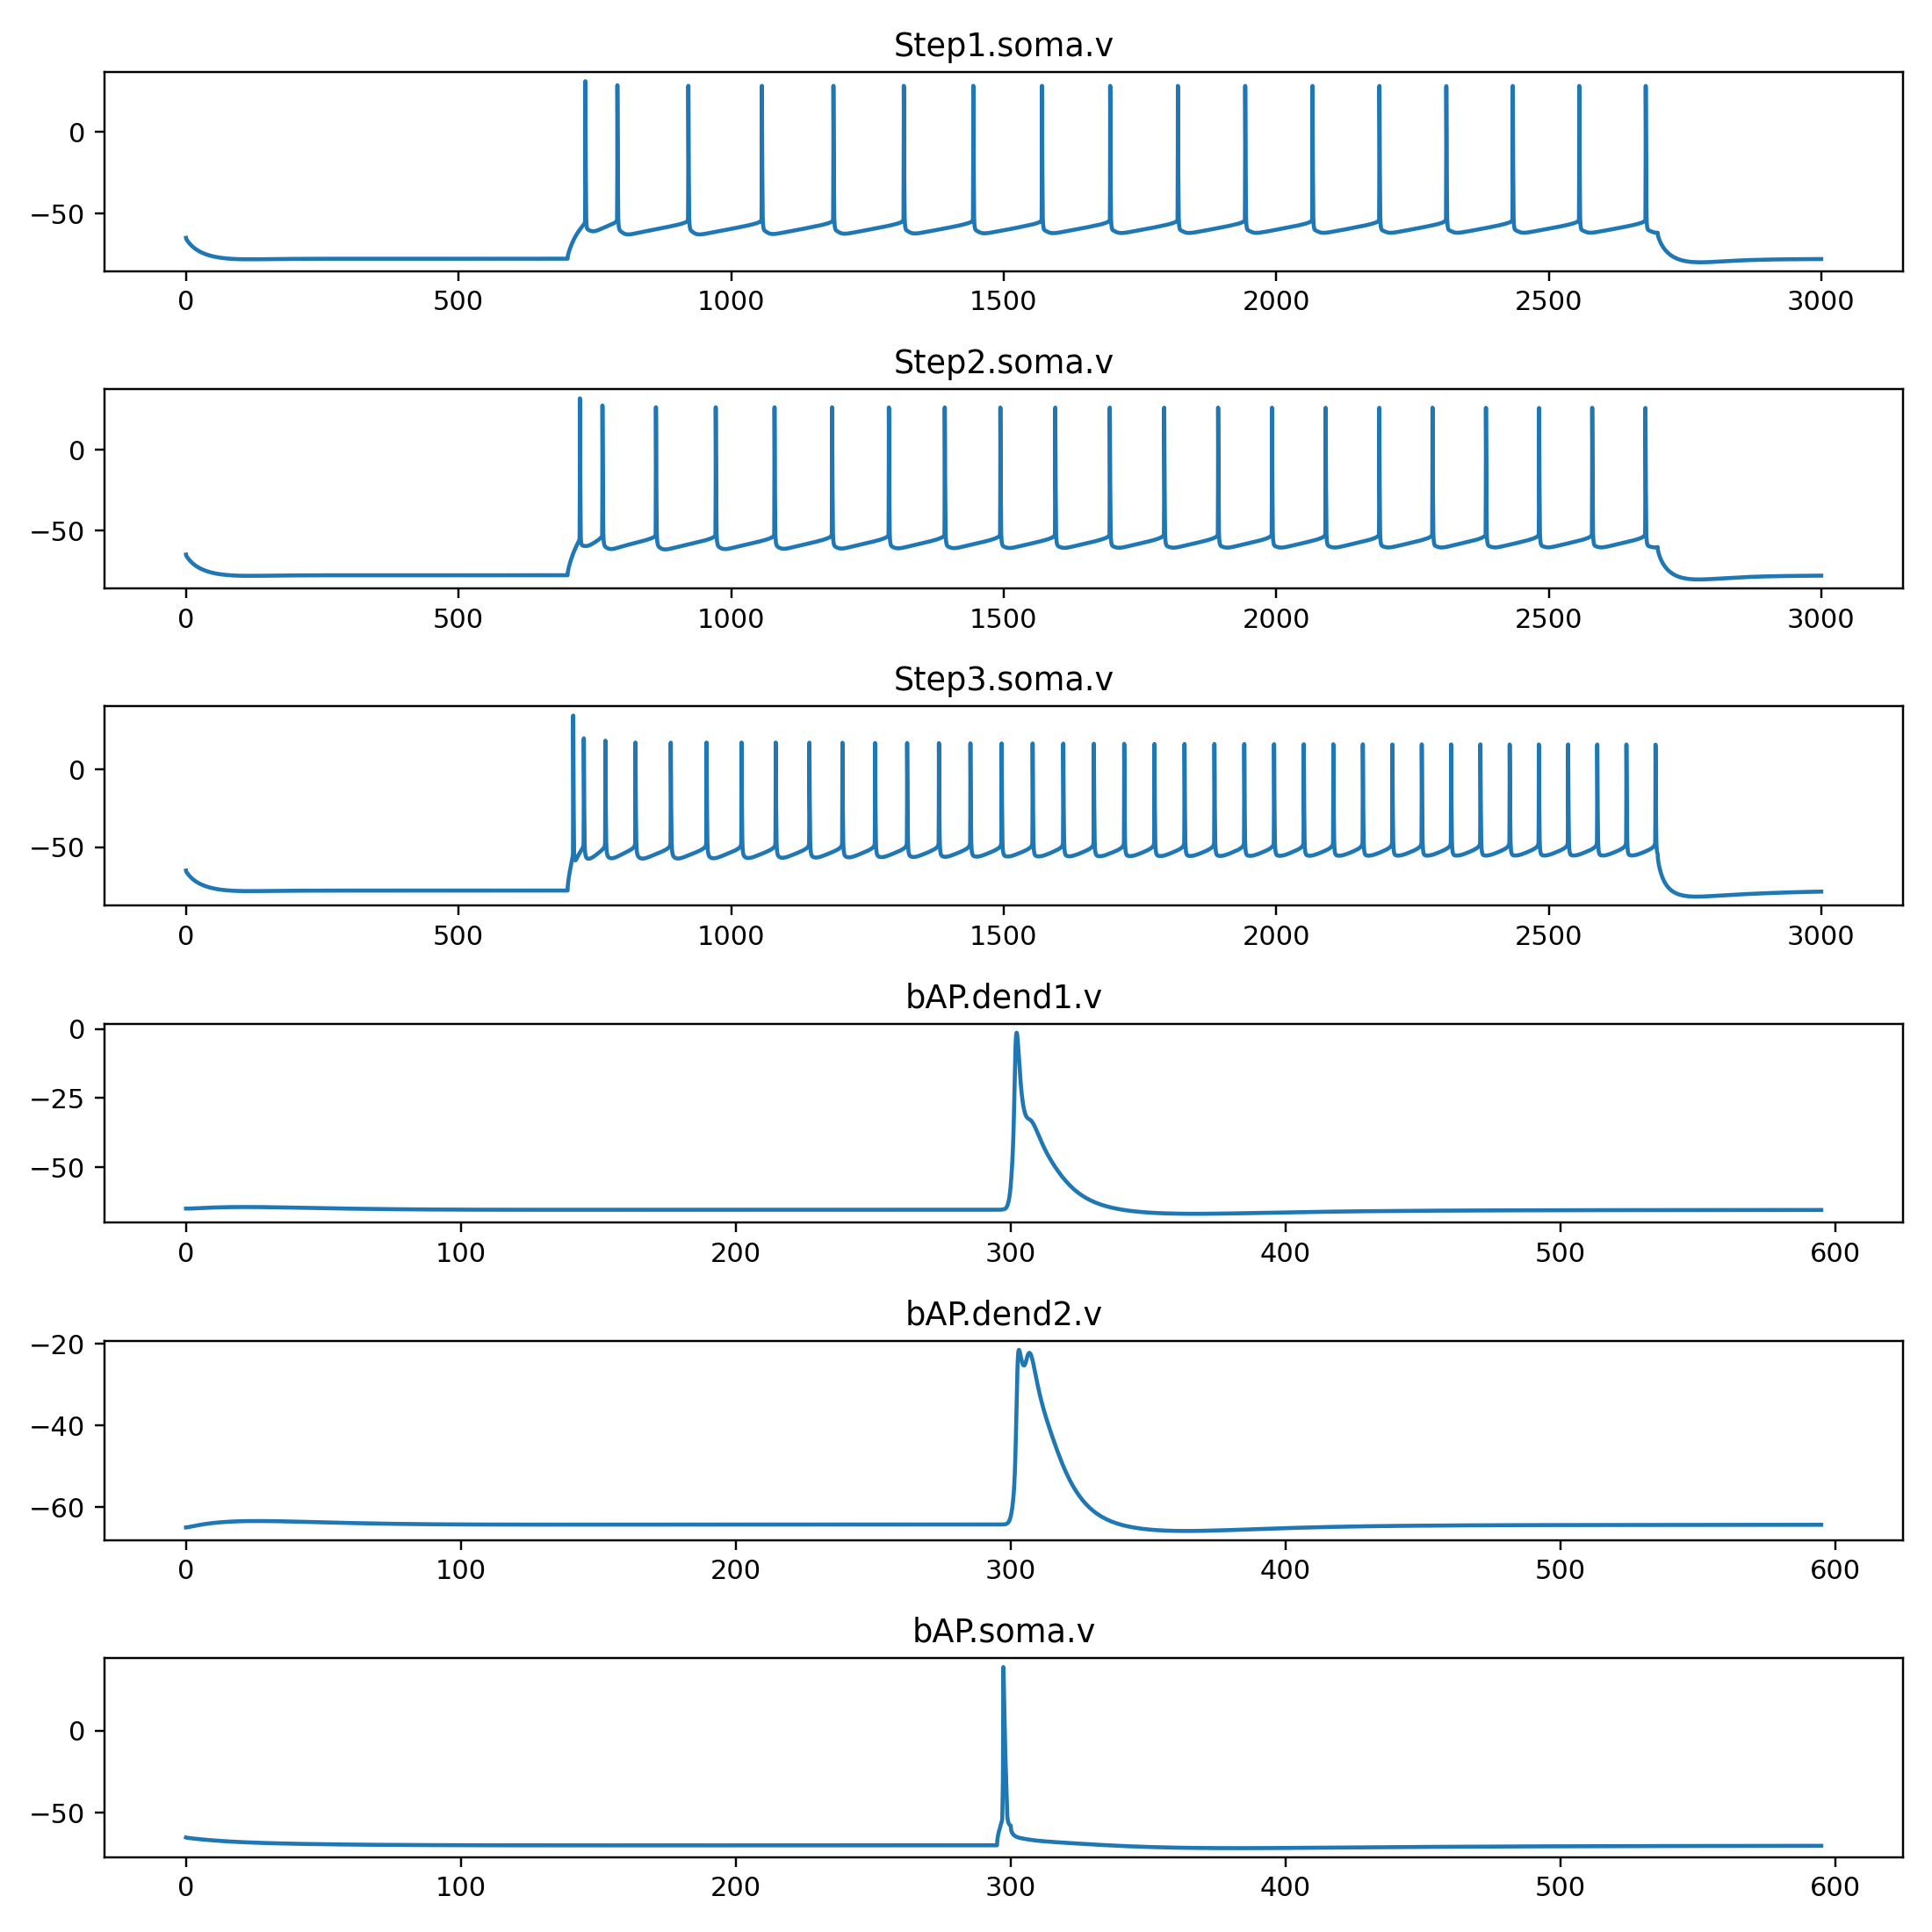

In [149]:
plot_responses(original_responses)

In [146]:
for param in best_params.keys():
    print(param, params[param],  best_params[param])

gNaTs2_tbar_NaTs2_t.apical 0.028444169845641038 0.03535590967065059
gSKv3_1bar_SKv3_1.apical 0.004417092861810175 0.01006249417738173
gImbar_Im.apical 0.00016109862450875326 0.00033358698752369555
gNaTa_tbar_NaTa_t.axonal 3.4712400439339515 3.5095765201667106
gNap_Et2bar_Nap_Et2.axonal 0.00642288532970085 0.00286447460997279
gK_Pstbar_K_Pst.axonal 0.9207787162564488 0.7109406713916887
gK_Tstbar_K_Tst.axonal 0.07147098593516947 0.07392323258925668
gSK_E2bar_SK_E2.axonal 0.007528294408347041 0.030002420698497356
gSKv3_1bar_SKv3_1.axonal 0.8198907815179834 0.7349390210209272
gCa_HVAbar_Ca_HVA.axonal 0.0008123583678578576 0.00042660186826392937
gCa_LVAstbar_Ca_LVAst.axonal 0.007411771430755678 0.00045273666980423115
gamma_CaDynamics_E2.axonal 0.003160609246050557 0.005717298938624367
decay_CaDynamics_E2.axonal 234.1632216435194 142.96122553749365
gNaTs2_tbar_NaTs2_t.somatic 0.9287730748213036 0.9138475210413891
gSKv3_1bar_SKv3_1.somatic 0.3391368412496218 0.3513130312212962
gSK_E2bar_SK_E2

In [147]:
!ls checkpoints/random_0/

bap_off250_ngen50.pkl  soma_off250_ngen50.pkl
